In [1]:
# imp|orts and settings
import pickle
from sklearn.metrics import mean_squared_error 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from itertools import product
import numpy as np
import pandas as pd
import os
import shutil
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import parameter_optimization as po
import concurrent.futures
import platform

# generate a matrix of different options, run GAMs a ton of times
# we are just using the current GAMs input files placed in data/save_for_GAMs

# settings
act_gene = 'b1187' # b3357 is crp, b1187 is fadR
inh_gene = None # b1594 is mlc, b3237 is argR
case = 'fadR_case' # crp_case, argR_case, different optimization for different entry sets

t_half_life_deg = 300
stable_flags = { # these do not change gene by gene
    # overall
    'run_basal_calculations' : False, # it is very slow and should only be necessary to run if something has changed basal conditions
    'only_create_ratios' : False,
    'only_check_KdRNAPCrp' : False, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    'remove_outliers' : True, # removes samples that do not correlate well with others, see ../data_cleaning/1_locate_outliers_to_drop.ipynb
    'case' : 'argR', # only used for remove_outliers right now
    'drop_basal_conds' : False, # if True, removes basal conditions from sample after they're used to calculate ratios (useful when their outliers)
    
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : False, # if True, return sanity plots from this optimization
    # GAMs
    'supress_output' : True, # don't show output from GAMs
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 1e-10,
    'act_TF_conc_up' : 1e-5,
    'act_Kd_lo' : 1e-10,
    'act_Kd_up' : 1e-6,
    'inh_TF_conc_lo' : 1e-10,
    'inh_TF_conc_up' : 1e-5,
    'inh_Kd_lo' : 1e-10,
    'inh_Kd_up' : 1e-6,
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : .1,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,


    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',

    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
}
if case == 'argR_case':
    stable_flags.update({'case' : case.split('_')[0],
                         'limit_samples' : ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'],
    })
elif case == 'fadR_case':
    stable_flags.update({'case' : case.split('_')[0],
                         'limit_samples' : ['b3255', 'b1288', 'b0185', 'b3256', 'b2316'],
                         })
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
TF_flags_df = pd.read_csv('../data/TF_saved_flags.csv', index_col = 0)
try:
    pickle_in = open('../GAMs/optimization_runs/'+case+'/iter_to_best_run_info.pkl', 'rb')
    iter_to_best_run_info = pickle.load(pickle_in)
    pickle_in.close()
except:
    iter_to_best_run_info = {}
        
if case == 'crp_case':
    # not set up yet, technically what it always was
    sweep_paras = ['act_TF_conc_lo', 'act_TF_conc_up', 'act_Kd_lo', 'act_Kd_up', 'weight_act_obj1', 'weight_mRNA_match', 'weight_act_corr']
elif case == 'fadR_case':
    all_paras = ['act_metab_Total_lo', 'act_metab_Total_up', 'inh_metab_Total_lo', 'inh_metab_Total_up', 'act_Kd_lo', 'act_Kd_up', 'weight_act_obj1', 'weight_mRNA_match', 'weight_act_corr']
    
    sweep_paras = ['act_Kd_lo', 'act_Kd_up', 'weight_act_obj1', 'weight_mRNA_match', 'weight_act_corr']
    
    starting_paras = {
        # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
        'act_TF_conc_lo' : 2.902870141566294e-13 / 1000, # minimum TF conc found in Heineman data
        'act_TF_conc_up' : 0.00014190659526601638 * 1000, # max of ^
        'act_Kd_lo' : 11e-9 / 1000, # 11 - 35 nM (1e-9) is the answer here - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4646316/
        'act_Kd_up' : 35e-9 * 1000, # from above
        'inh_TF_conc_lo' : 2.902870141566294e-13 / 1000, # minimum TF conc found in Heineman data
        'inh_TF_conc_up' : 0.00014190659526601638 * 1000, # max of ^
        'inh_Kd_lo' : 11e-9 / 1000, # 11 - 35 nM (1e-9) is the answer here - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4646316/
        'inh_Kd_up' : 35e-9 * 1000, # from above
        'inh_metab_Total_lo' : 0.000038 / 1000, # minimum of arginine concentration in stationary phase samples, div a buffer
        'inh_metab_Total_up' : 0.000408 * 1000, # maximum of arginine concentration in stationary phase samples, mult a buffer
        'act_metab_Total_lo' : 0.000038 / 1000, # minimum of arginine concentration in stationary phase samples, div a buffer
        'act_metab_Total_up' : 0.000408 * 1000, # maximum of arginine concentration in stationary phase samples, mult a buffer
        
        # objective function weightings
        'weight_act_obj1' : 1,
        'weight_inh_obj1' : 1,
        'weight_act_obj2' : 0,
        'weight_inh_obj2' : 0,
        'weight_mRNA_match' : 0.0001,
        'weight_act_corr' : 0.00000000000000001,
        'weight_inh_corr' : 0.00000000000000001,
    }
    best_paras = starting_paras
elif case == 'argR_case':
    all_paras = ['inh_metab_Total_lo', 'inh_metab_Total_up', 'act_Kd_lo', 'act_Kd_up', 'weight_act_obj1', 'weight_mRNA_match', 'weight_act_corr']
    #sweep_paras = ['inh_metab_Total_lo', 'inh_metab_Total_up', 'act_Kd_lo', 'act_Kd_up', 'weight_act_obj1', 'weight_mRNA_match', 'weight_act_corr']
    
    # removing inh_metab from this, trying to have it hard set to data, make rest match to it
    sweep_paras = ['act_Kd_lo', 'act_Kd_up', 'weight_act_obj1', 'weight_mRNA_match', 'weight_act_corr']

    ## best parameters from most recent run
    starting_paras = {
        'act_TF_conc_lo' : 2.902870141566294e-13 / 100, # minimum TF conc found in Heineman data
        'act_TF_conc_up' : 0.00014190659526601638 * 100, # max of ^
        'act_Kd_lo' : 11e-9 / 100, # 11 - 35 nM (1e-9) is the answer here - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4646316/
        'act_Kd_up' : 35e-9 * 100, # from above
        'inh_TF_conc_lo' : 2.902870141566294e-13 / 100, # minimum TF conc found in Heineman data
        'inh_TF_conc_up' : 0.00014190659526601638 * 100, # max of ^
        'inh_Kd_lo' : 11e-9 / 100, # 11 - 35 nM (1e-9) is the answer here - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4646316/
        'inh_Kd_up' : 35e-9 * 100, # from above
        'inh_metab_Total_lo' : 0.000038 / 100, # minimum of arginine concentration in stationary phase samples, div a buffer
        'inh_metab_Total_up' : 0.000408 * 100, # maximum of arginine concentration in stationary phase samples, mult a buffer
        'weight_act_obj1' : 0,
        'weight_inh_obj1' : 9.256244e-03,
        'weight_act_obj2' : 0,
        'weight_inh_obj2' : 0,
        'weight_mRNA_match' : 2.650902e+00,
        'weight_act_corr' : 0,
        'weight_inh_corr' : 6.922027e-34,
    }
    best_paras = starting_paras

# make it all a massive loop that improves on each run

In [ ]:
# settings and run
loop_total = 50  # let's start with 10 loops
n_range = 3 # hard set to this now, but some other variables use it
# constants
cell_constants = {
    'RNAP' : stable_flags['cell_constants_RNAP'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
    'cell_volume' : stable_flags['cell_constants_cell_volume'],
    'kDeg' : stable_flags['cell_constants_kDeg'],
    'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
}

def mask_func(inp0, inp1, inp2, inp3, inp4, inp5, inp6, inp7):
    if os.path.exists(inp6):
        shutil.rmtree(inp6, ignore_errors = True)
    os.mkdir(inp6)
    os.mkdir(inp6+'/input_files')
    os.mkdir(inp6+'/output_files')
    os.mkdir(inp6+'/input_GDX')
    os.mkdir(inp6+'/output_GDX')
    iG.run_GAMs(inp0, inp1, inp2, inp3, inp4, inp5, inp6, parameter_flags = inp7)

# first loop settings
reduce_amt = 0.8 # reduces the change val each loop to "zoom in" on a good answer
if len(iter_to_best_run_info) == 0:
    iter_ct = 1
    if case != 'argR_case':
        starting_index = (0, 0, 0, 0, 0, 0, 0)
        best_paras = {'act_TF_conc_lo': 1e-11, 'act_TF_conc_up': 1e-05, 'act_Kd_lo': 1e-11, 'act_Kd_up': 1e-06, 'inh_TF_conc_lo': 1e-11, 'inh_TF_conc_up': 1e-05, 'inh_Kd_lo': 1e-11, 'inh_Kd_up': 1e-06, 'weight_act_obj1': 0.1, 'weight_inh_obj1': 0.1, 'weight_act_obj2': 0.0, 'weight_inh_obj2': 0.0, 'weight_mRNA_match': 0.055, 'weight_act_corr': 1e-17, 'weight_inh_corr': 1e-17}
        change_val = 5 # val / (1+this), val, val * (1+this) are the three tested for each dimension
    else:
        starting_index = tuple([0 for _ in range(len(sweep_paras))])
        #best_paras is set above already
        change_val = 5
else:
    max_iter = max(iter_to_best_run_info.keys())
    iter_ct = max_iter + 1
    starting_index = iter_to_best_run_info[max_iter][0]
    best_paras = dict(pd.read_csv(iter_to_best_run_info[max_iter][2]+'/input_files/parameters.csv', index_col = 0))['Value']
    change_val = iter_to_best_run_info[max_iter][1] * reduce_amt

while iter_ct < loop_total:
    print('working on iter_ct : '+str(iter_ct))
    
    ############################
    # Generate inputs
    ############################
    lists = []
    para_to_list = {}
    for index, para in zip(starting_index, sweep_paras):
        if index == 1: # this means the ideal value was the center, to mix it up let's reduce its change some to find a more local minima
            temp_change_val = (change_val / 2) + 1
        else:
            temp_change_val = change_val + 1
        if 'act' in para and not act_gene: # if there is no promoter
            if best_paras[para.replace('act', 'inh')] != 0:
                best_paras[para] = best_paras[para.replace('act', 'inh')]
        if 'inh' in para and not inh_gene: # if there is no inhibitor
            if best_paras[para.replace('inh', 'act')] != 0:
                best_paras[para] = best_paras[para.replace('inh', 'act')]
        list_ = [best_paras[para] / temp_change_val, best_paras[para], temp_change_val * best_paras[para]]#np.linspace(best_paras[para] - change_val*best_paras[para], best_paras[para] + change_val*best_paras[para], n_range)
        para_to_list.update({para : list_})
        lists.append(list_)
    combos = product(*lists)
    i = 0
    inputs = []
    i_to_index = {}
    if not os.path.exists('../GAMs/optimization_runs/'+case):
        os.mkdir('../GAMs/optimization_runs/'+case)
    if not os.path.exists('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)):
        os.mkdir('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct))
    for combo in list(combos):
        index_vals = []
        para_dict = {}
        for para, val in zip(sweep_paras, combo):
            if 'act_' in para:
                para2 = para.replace('act_', 'inh_')
            elif 'inh_' in para:
                para2 = para.replace('inh_', 'act_')
            else:
                para2 = None
            para_dict.update({para : val})
            if para2:
                para_dict.update({para2 : val})
            index_vals.append(list(para_to_list[para]).index(val))
        
        # round out the para_dict
        for para in all_paras:
            if para not in para_dict:
                para_dict.update({para : starting_paras[para]})
        
        i_to_index.update({i : tuple(index_vals)})
        GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/run_'+str(i)
        inputs.append((flags_df, TF_flags_df, stable_flags, act_gene, inh_gene, cell_constants, GAMs_run_dir, para_dict))
        i += 1
    pickle_out = open('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/i_to_index.pkl', 'wb')
    pickle.dump(i_to_index, pickle_out)
    pickle_out.close()
    index_to_i = {v : k for k, v in i_to_index.items()}

    
    ############################
    # Run GAMs
    ############################
    if platform.system() != 'Windows':
        with Pool(processes = 16) as pool:
            results = pool.starmap(mask_func, inputs)
            #results = pool.starmap(mask_func, inputs)
    else:
        with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
            results = executor.map(lambda args: mask_func(*args), inputs)


    ############################
    # Read results
    ############################
    size = (n_range,) * len(sweep_paras)
    saved_act_corrs = np.zeros(size)
    saved_inh_corrs = np.zeros(size)
    saved_mRNA_errs = np.zeros(size)

    mRNA_ratio = pd.read_csv('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/run_0/input_files/actual_mRNA_ratio.csv', index_col = 0)
    input_cAct = pd.read_csv('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/run_0/input_files/composite_cAct_vals.csv', index_col = 0)
    input_cInh = pd.read_csv('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/run_0/input_files/composite_cInh_vals.csv', index_col = 0)
    grid = pd.read_csv('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/run_0/input_files/grid_constants.csv', index_col = 0)
    real_act_TF_conc = pd.read_csv('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/run_0/input_files/exported_act_TF_conc.csv', index_col = 0)
    real_inh_TF_conc = pd.read_csv('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/run_0/input_files/exported_inh_TF_conc.csv', index_col = 0)

    gene_to_lambda_df = {}
    for gene in input_cAct.columns:
        gene_to_lambda_df.update({gene : po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid[gene]))})

    ct = 0
    tot = len(os.listdir('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)))
    for f in os.listdir('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)):
        ct += 1
        if 'run_' not in f: continue
        # read in data
        #paras_df = pd.read_csv('../GAMs/optimization_runs/'+f+'/input_files/parameters.csv', index_col = 0)
        try:
            calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs('../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/'+f)
        except:
            index = i_to_index[int(f.split('_')[1])]
            saved_mRNA_errs[index] = -1
            continue

        # get average cAct/cInh correlations
        act_corrs = []
        inh_corrs = []
        for gene in calc_cAct.columns:
            if act_gene:
                cAct_corr = np.corrcoef(list(calc_cAct[gene].values), list(input_cAct[gene].values))[0][1]
                act_corrs.append(cAct_corr)
            else:
                act_corrs.append(0)
            if inh_gene:
                cInh_corr = np.corrcoef(list(calc_cInh[gene].values), list(input_cInh[gene].values))[0][1]
                inh_corrs.append(cInh_corr)
            else:
                inh_corrs.append(0)
        act_corr = np.mean(act_corrs)
        inh_corr = np.mean(inh_corrs)

        # I need recreated cActivators and cInhibitors
        recons_mRNAs = []
        for gene in calc_cAct.columns:
            recon_mRNA = []
            for cAct, cInh in zip(calc_cAct[gene], calc_cInh[gene]):
                recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp'], lambda_df_input = gene_to_lambda_df[gene]))
            recons_mRNAs.append(recon_mRNA)
        recon_df = pd.DataFrame(recons_mRNAs, columns = calc_cAct.index, index = calc_cAct.columns).T
        recon_df = recon_df.loc[mRNA_ratio.index]
        errs = []
        for column in mRNA_ratio.columns:
            #corr = np.corrcoef(recon_df[column], mRNA_ratio[column])[0][1]
            err = mean_squared_error(recon_df[column], mRNA_ratio[column])
            errs.append(err)
        mRNA_err = np.mean(errs)

        # save values
        index = i_to_index[int(f.split('_')[1])]
        saved_act_corrs[index] = act_corr
        saved_inh_corrs[index] = inh_corr
        saved_mRNA_errs[index] = mRNA_err


    ############################
    # save best result
    ############################
    # scale saved_mRNA_errs
    saved_mRNA_errs[saved_mRNA_errs == -1] = max(saved_mRNA_errs.flatten()) # set the errored values to the max squared error so they don't get picked
    saved_mRNA_errs /= max(saved_mRNA_errs.flatten())
    combo = saved_act_corrs + saved_inh_corrs - saved_mRNA_errs
    overall_best = np.unravel_index(np.argmax(combo, axis=None), np.shape(combo))
    GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/iter_'+str(iter_ct)+'/run_'+str(index_to_i[overall_best])
    params = pd.read_csv(GAMs_run_dir+'/input_files/parameters.csv', index_col = 0)
    print(overall_best)
    print(dict(params['Value']))
    print('Overall_score: '+str(combo[overall_best]))
    print('cAct_corr: '+str(saved_act_corrs[overall_best]))
    print('cInh_corr: '+str(saved_inh_corrs[overall_best]))
    print('mRNA_err: '+str(saved_mRNA_errs[overall_best]))
    print('\n')
    iter_to_best_run_info.update({iter_ct : (overall_best, change_val, GAMs_run_dir)})
    pickle_out = open('../GAMs/optimization_runs/'+case+'/iter_to_best_run_info.pkl', 'wb')
    pickle.dump(iter_to_best_run_info, pickle_out)
    pickle_out.close()
    pickle_out = open('../GAMs/optimization_runs/'+case+'/index_to_i.pkl', 'wb')
    pickle.dump(index_to_i, pickle_out)
    pickle_out.close()
    
    # setup for next loop
    iter_ct += 1
    change_val *= reduce_amt
    best_paras = dict(pd.read_csv(GAMs_run_dir+'/input_files/parameters.csv', index_col = 0))['Value']
    print('next change_val : ', end = '')
    print(change_val)
    print()

working on iter_ct : 3


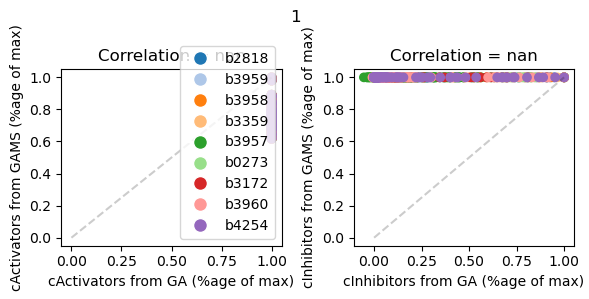

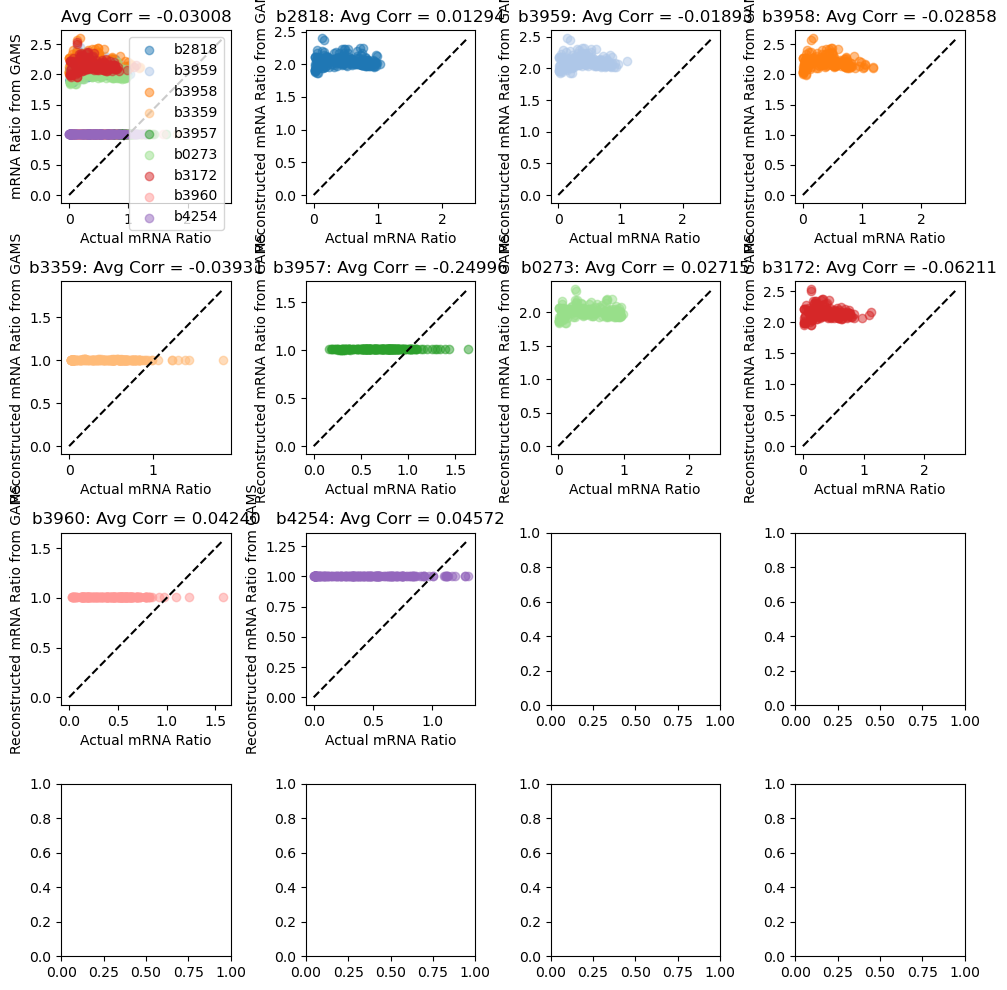

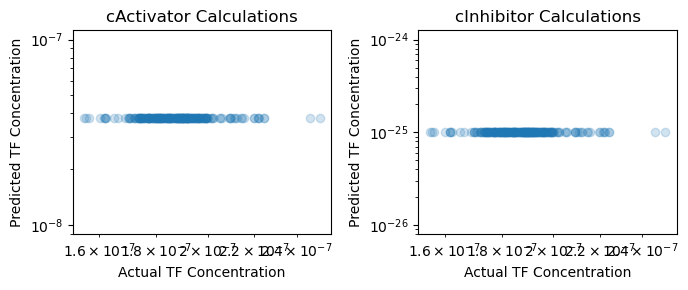

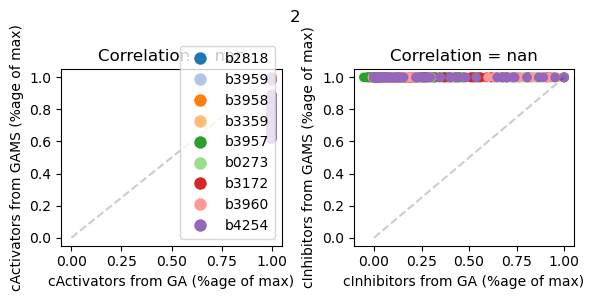

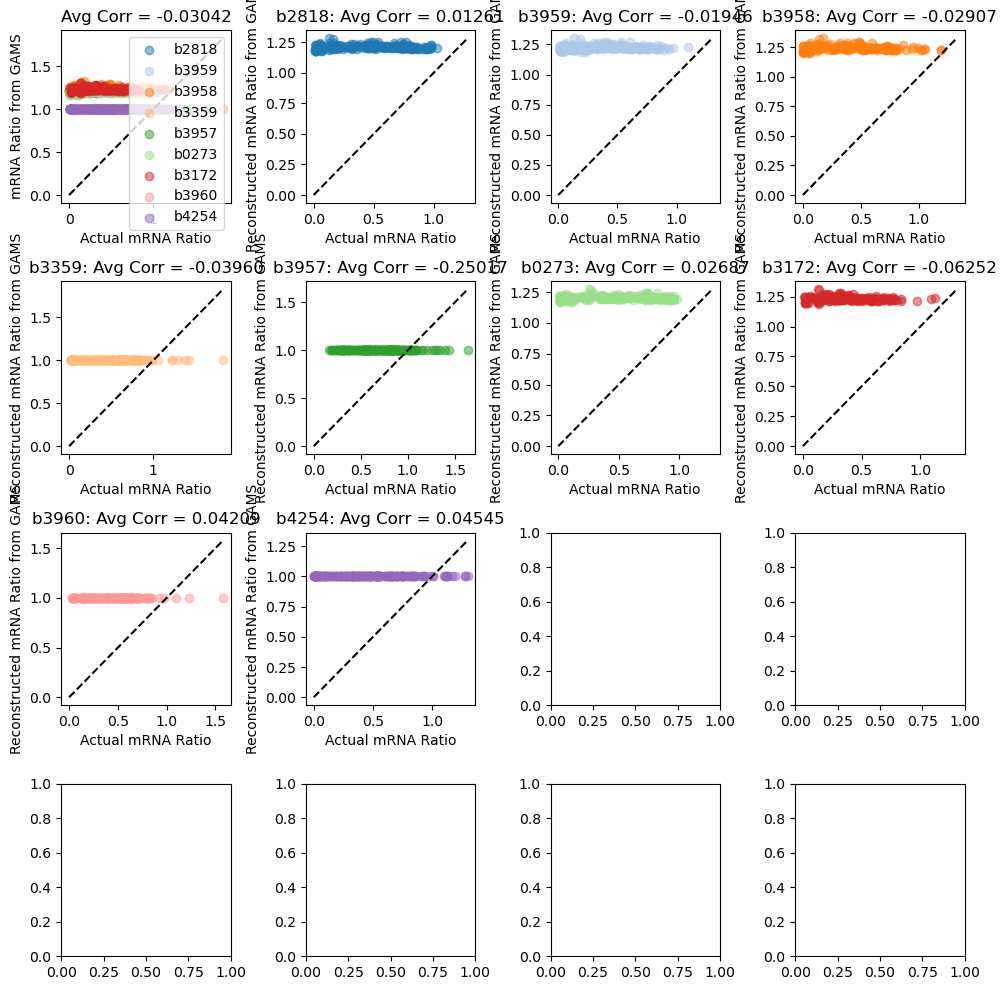

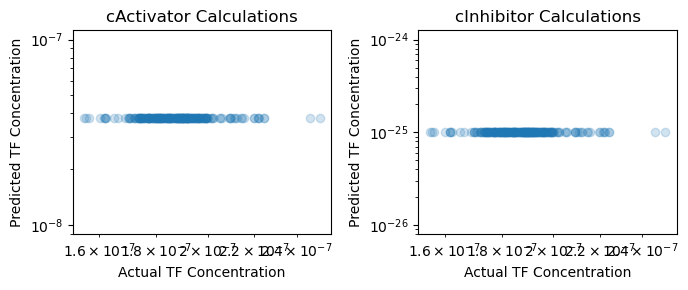

In [3]:
# load and view
pickle_in = open('../GAMs/optimization_runs/'+case+'/iter_to_best_run_info.pkl', 'rb')
iter_to_best_run_info = pickle.load(pickle_in)
pickle_in.close()

first = True # delete me
for iter_ct, run_info in list(iter_to_best_run_info.items())[-2:]:    

    GAMs_run_dir = run_info[2]
    
    # read and display GAMs
    calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(GAMs_run_dir)
    # look at GAMs results
    scale_to_100_perc = True # scale cAct / cInh by 100%

    # load in cActivators
    saved_cActivators = pd.read_csv(GAMs_run_dir+'/input_files/composite_cAct_vals.csv', index_col = 0)

    # plotting
    saved = []
    calc = []
    labels = []
    gene_to_color = {}
    cmap = cm.get_cmap('tab20')
    color_opts = iter(cmap.colors)
    colors = []
    for gene in calc_cAct.columns:
        if gene not in gene_to_color:
            gene_to_color.update({gene : next(color_opts)})
        color = gene_to_color[gene]
        for sample in calc_cAct.index:
            if scale_to_100_perc:
                saved.append(saved_cActivators.loc[sample][gene] / max(saved_cActivators[gene]))
                calc.append(calc_cAct.loc[sample][gene] / max(calc_cAct[gene]))
            else:
                saved.append(saved_cActivators.loc[sample][gene])
                calc.append(calc_cAct.loc[sample][gene])
            labels.append(gene+', '+sample)
            colors.append(color)
    fig, axs = plt.subplots(1, 2, figsize = (6, 3))
    scatter = axs[0].scatter(saved, calc, c = colors)
    if scale_to_100_perc:
        axs[0].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
    else:
        axs[0].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
    if scale_to_100_perc:
        axs[0].set_xlabel('cActivators from GA (%age of max)')
        axs[0].set_ylabel('cActivators from GAMS (%age of max)')
    else:
        axs[0].set_xlabel('cActivators from GA')
        axs[0].set_ylabel('cActivators from GAMS')
    corr = np.corrcoef(saved, calc)
    axs[0].set_title('Correlation = {:.2f}'.format(corr[1][0]))
    #plt.yscale('log')
    #plt.xscale('log')

    # Create an empty list to store legend handles and labels
    legend_elements = []
    for label, color in gene_to_color.items():
        legend_elements.append(plt.Line2D([0], [0], marker = 'o', color = 'w', markersize = 10, markerfacecolor = color, label = label))
    axs[0].legend(handles = legend_elements, loc = 'lower right')


    # now plot cInhibitor
    # load in cActivators
    saved_cActivators = pd.read_csv(GAMs_run_dir+'/input_files/composite_cInh_vals.csv', index_col = 0)

    # plotting
    saved = []
    calc = []
    labels = []
    gene_to_color = {}
    cmap = cm.get_cmap('tab20')
    color_opts = iter(cmap.colors)
    colors = []
    for gene in calc_cInh.columns:
        if gene not in gene_to_color:
            gene_to_color.update({gene : next(color_opts)})
        color = gene_to_color[gene]
        for sample in calc_cInh.index:
            if scale_to_100_perc:
                saved.append(saved_cActivators.loc[sample][gene] / max(saved_cActivators[gene]))
                calc.append(calc_cInh.loc[sample][gene] / max(calc_cInh[gene]))
            else:
                saved.append(saved_cActivators.loc[sample][gene])
                calc.append(calc_cInh.loc[sample][gene])
            labels.append(gene+', '+sample)
            colors.append(color)
    scatter = axs[1].scatter(saved, calc, c = colors)
    if scale_to_100_perc:
        axs[1].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
    else:
        axs[1].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
    if scale_to_100_perc:
        axs[1].set_xlabel('cInhibitors from GA (%age of max)')
        axs[1].set_ylabel('cInhibitors from GAMS (%age of max)')
    else:
        axs[1].set_xlabel('cInhibitors from GA')
        axs[1].set_ylabel('cInhibitors from GAMS')
    corr = np.corrcoef(saved, calc)
    axs[1].set_title('Correlation = {:.2f}'.format(corr[1][0]))
    #plt.yscale('log')
    #plt.xscale('log')
    plt.suptitle(iter_ct)
    fig.tight_layout()
    plt.show()


    # I need recreated cActivators and cInhibitors
    colors = iter(plt.cm.tab20.colors)
    shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    corrs = []
    recons_mRNAs = []
    actual_mRNAs = []
    indices_for_recons = []
    max_mRNA = 0
    dims = int(np.sqrt(len(calc_cAct.columns)))+1
    fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
    axs = axs.flatten()
    #plt.figure(figsize = (4, 4))
    g_ct = 1
    grid = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0)
    ratios_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
    for gene in calc_cAct.columns:
        actual_mRNAs.append(ratios_df.loc[shared][gene])
        # setup
        po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid[gene]))

        recon_mRNA = []
        for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp']))
        recons_mRNAs.append(recon_mRNA)
        indices_for_recons.append(gene)

        actual_mRNA = ratios_df.loc[shared][gene].values.flatten()
        if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
            max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
        max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

        corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
        corrs.append(corr[0][1])
        c = next(colors)
        axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
        axs[g_ct].set_title(gene+': Avg Corr = {:.5f}'.format(corr[0][1]))
        axs[g_ct].set_xlabel('Actual mRNA Ratio')
        axs[g_ct].set_ylabel('Reconstructed mRNA Ratio from GAMS')
        g_ct += 1


    axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
    axs[0].legend()
    axs[0].set_title('Avg Corr = {:.5f}'.format(np.mean(corrs)))
    axs[0].set_xlabel('Actual mRNA Ratio')
    axs[0].set_ylabel('mRNA Ratio from GAMS')
    plt.tight_layout()
    plt.show()



    # TF conc values
    # histogram of TF_conc values
    actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_act_TF_conc.csv', index_col = 0)
    TF_conc_df = cAct_TF_conc_df
    fig, axs = plt.subplots(1, 2, figsize = (7, 3))
    axs[0].scatter(actual_TF_conc_df.loc[shared], TF_conc_df.T.loc[shared], alpha = 0.2)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Actual TF Concentration')
    axs[0].set_ylabel('Predicted TF Concentration')
    axs[0].set_title('cActivator Calculations')

    actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_inh_TF_conc.csv', index_col = 0)
    TF_conc_df = cInh_TF_conc_df
    axs[1].scatter(actual_TF_conc_df.loc[shared], TF_conc_df.T.loc[shared], alpha = 0.2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Actual TF Concentration')
    axs[1].set_ylabel('Predicted TF Concentration')
    axs[1].set_title('cInhibitor Calculations')
    plt.tight_layout()
    plt.show()

In [4]:
# save off best parameters to a dictionary
pickle_in = open('../GAMs/optimization_runs/'+case+'/iter_to_best_run_info.pkl', 'rb')
iter_to_best_run_info = pickle.load(pickle_in)
pickle_in.close()
k = max(iter_to_best_run_info.keys())
paras_df = pd.read_csv(iter_to_best_run_info[k][2]+'/input_files/parameters.csv', index_col = 0)

if os.path.exists('../data/case_to_best_paras.pkl'):
    pickle_in = open('../data/case_to_best_paras.pkl', 'rb')
    case_to_best_paras = pickle.load(pickle_in)
    pickle_in.close()
else:
    case_to_best_paras = {}
    
case_to_best_paras.update({case : paras_df})
pickle_out = open('../data/case_to_best_paras.pkl', 'wb')
pickle.dump(case_to_best_paras, pickle_out)
pickle_out.close()

# original one run at a time version

In [6]:
# generate large list of sets of stable_flags with varying constants to run on
n_range = 3
change_val = 0.2
lists = []
paras = ['act_TF_conc_lo', 'act_TF_conc_up', 'act_Kd_lo', 'act_Kd_up', 'weight_act_obj1', 'weight_mRNA_match', 'weight_act_corr']
para_to_list = {}
for para in paras:
    list_ = np.linspace(best_paras[para] - change_val*best_paras[para], best_paras[para] + change_val*best_paras[para], n_range)
    para_to_list.update({para : list_})
    lists.append(list_)
combos = product(*lists)

cell_constants = {}
cell_constants.update({
    'RNAP' : stable_flags['cell_constants_RNAP'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
    'cell_volume' : stable_flags['cell_constants_cell_volume'],
    'kDeg' : stable_flags['cell_constants_kDeg'],
    'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
})

i = 0
inputs = []
i_to_index = {}
if not os.path.exists('../GAMs/optimization_runs/iter_'+str(iter_ct)):
    os.mkdir('../GAMs/optimization_runs/iter_'+str(iter_ct))
for combo in list(combos):
    para_dict = {
        'act_TF_conc_lo' : combo[0],
        'act_TF_conc_up' : combo[1],
        'act_Kd_lo' : combo[2],
        'act_Kd_up' : combo[3],
        'inh_TF_conc_lo' : combo[0],
        'inh_TF_conc_up' : combo[1],
        'inh_Kd_lo' : combo[2],
        'inh_Kd_up' : combo[3],

        'weight_act_obj1' : combo[4],
        'weight_inh_obj1' : combo[4],
        'weight_act_obj2' : 0,
        'weight_inh_obj2' : 0,
        'weight_mRNA_match' : combo[5],
        'weight_act_corr' : combo[6],
        'weight_inh_corr' : combo[6],
    }
    i_to_index.update({i : (
        list(para_to_list['act_TF_conc_lo']).index(combo[0]),
        list(para_to_list['act_TF_conc_up']).index(combo[1]),
        list(para_to_list['act_Kd_lo']).index(combo[2]),
        list(para_to_list['act_Kd_up']).index(combo[3]),
        list(para_to_list['weight_act_obj1']).index(combo[4]),
        list(para_to_list['weight_mRNA_match']).index(combo[5]),
        list(para_to_list['weight_act_corr']).index(combo[6]),
    )})
    GAMs_run_dir = '../GAMs/optimization_runs/iter_'+str(iter_ct)+'/run_'+str(i)
    inputs.append((flags_df, stable_flags, 'b3357', 'b1594', cell_constants, GAMs_run_dir, para_dict))
    i += 1

In [ ]:
# run GAMs
def mask_func(inp0, inp1, inp2, inp3, inp4, inp5, inp6):
    if os.path.exists(inp5):
        shutil.rmtree(inp5, ignore_errors = True)
    os.mkdir(inp5)
    os.mkdir(inp5+'/input_files')
    os.mkdir(inp5+'/output_files')
    os.mkdir(inp5+'/input_GDX')
    os.mkdir(inp5+'/output_GDX')
    iG.run_GAMs(inp0, inp1, inp2, inp3, inp4, inp5, parameter_flags = inp6)
print(len(inputs), end = ' total runs to be done ... ')
print('\nto check progress, look at number of run_N folders in GAMs/optimization_runs/')
with Pool(processes = 16) as pool:
    results = pool.starmap(mask_func, inputs)

2187 total runs to be done ... 
to check progress, look at number of run_N folders in GAMs/optimization_runs/


In [8]:
# intepret results to look for best values
size = (n_range,) * len(paras)
saved_act_corrs = np.zeros(size)
saved_inh_corrs = np.zeros(size)
saved_mRNA_corrs = np.zeros(size)

mRNA_ratio = pd.read_csv('../GAMs/optimization_runs/iter_'+str(iter_ct)+'/run_0/input_files/actual_mRNA_ratio.csv', index_col = 0)
input_cAct = pd.read_csv('../GAMs/optimization_runs/iter_'+str(iter_ct)+'/run_0/input_files/composite_cAct_vals.csv', index_col = 0)
input_cInh = pd.read_csv('../GAMs/optimization_runs/iter_'+str(iter_ct)+'/run_0/input_files/composite_cInh_vals.csv', index_col = 0)
grid = pd.read_csv('../GAMs/optimization_runs/iter_'+str(iter_ct)+'/run_0/input_files/grid_constants.csv', index_col = 0)
real_act_TF_conc = pd.read_csv('../GAMs/optimization_runs/iter_'+str(iter_ct)+'/run_0/input_files/exported_act_TF_conc.csv', index_col = 0)
real_inh_TF_conc = pd.read_csv('../GAMs/optimization_runs/iter_'+str(iter_ct)+'/run_0/input_files/exported_inh_TF_conc.csv', index_col = 0)

gene_to_lambda_df = {}
for gene in input_cAct.columns:
    gene_to_lambda_df.update({gene : po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid[gene]))})

ct = 0
tot = len(os.listdir('../GAMs/optimization_runs/iter_'+str(iter_ct)))
for f in os.listdir('../GAMs/optimization_runs/iter_'+str(iter_ct)):
    ct += 1
    if 'run_' not in f: continue
    print('\rprogress: {:.2f}%'.format(100*ct/tot), end = '\r')
    # read in data
    #paras_df = pd.read_csv('../GAMs/optimization_runs/'+f+'/input_files/parameters.csv', index_col = 0)
    try:
        calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs('../GAMs/optimization_runs/iter_'+str(iter_ct)+'/'+f)
    except:
        continue
        
    # get average cAct/cInh correlations
    act_corrs = []
    inh_corrs = []
    for gene in calc_cAct.columns:
        cAct_corr = np.corrcoef(list(calc_cAct[gene].values), list(input_cAct[gene].values))[0][1]
        cInh_corr = np.corrcoef(list(calc_cInh[gene].values), list(input_cInh[gene].values))[0][1]
        act_corrs.append(cAct_corr)
        inh_corrs.append(cInh_corr)
    act_corr = np.mean(act_corrs)
    inh_corr = np.mean(inh_corrs)
    
    # I need recreated cActivators and cInhibitors
    recons_mRNAs = []
    for gene in calc_cAct.columns:
        recon_mRNA = []
        for cAct, cInh in zip(calc_cAct[gene], calc_cInh[gene]):
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp'], lambda_df_input = gene_to_lambda_df[gene]))
        recons_mRNAs.append(recon_mRNA)
    recon_df = pd.DataFrame(recons_mRNAs, columns = calc_cAct.index, index = calc_cAct.columns).T
    recon_df = recon_df.loc[mRNA_ratio.index]
    corrs = []
    for column in mRNA_ratio.columns:
        corr = np.corrcoef(recon_df[column], mRNA_ratio[column])[0][1]
        corrs.append(corr)
    mRNA_corr = np.mean(corrs)
    
    # save values
    index = i_to_index[int(f.split('_')[1])]
    saved_act_corrs[index] = act_corr
    saved_inh_corrs[index] = inh_corr
    saved_mRNA_corrs[index] = mRNA_corr
print()


KeyboardInterrupt



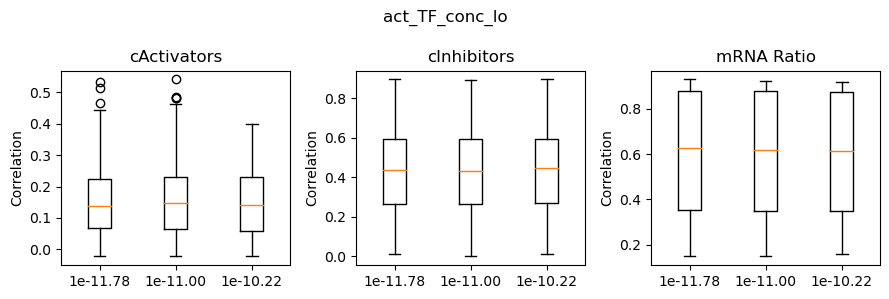

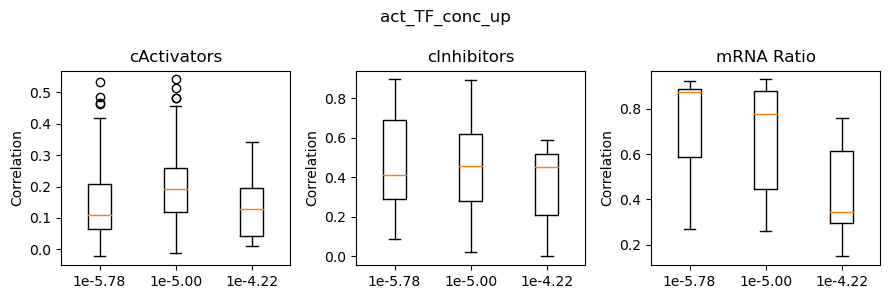

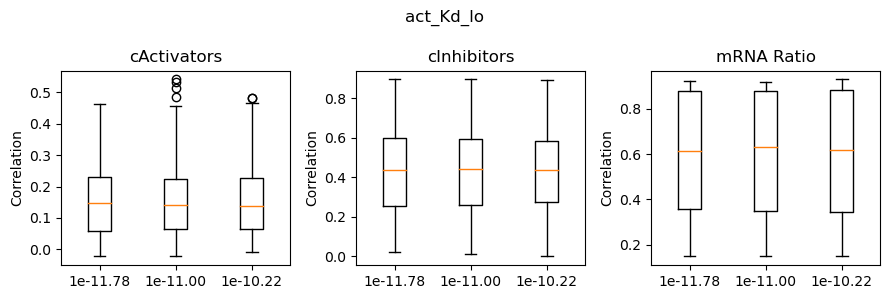

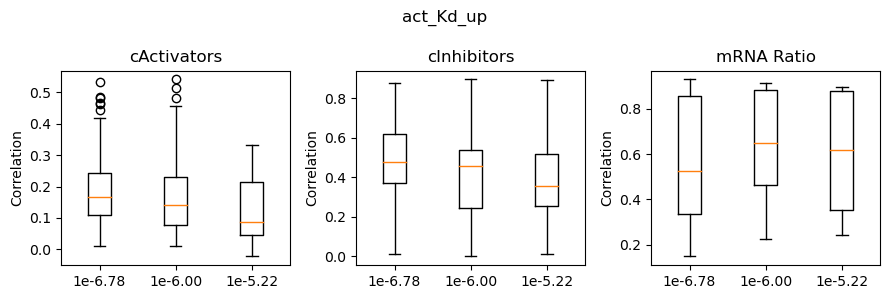

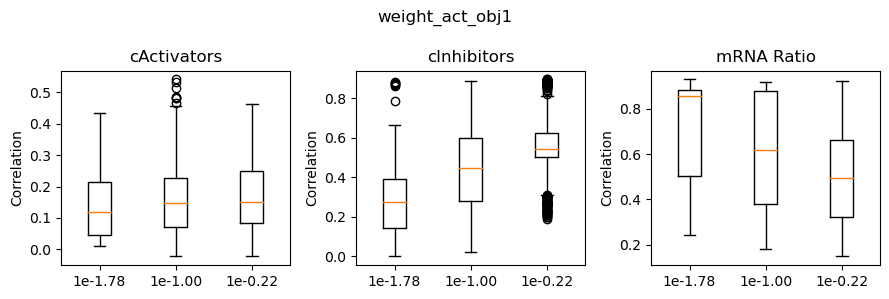

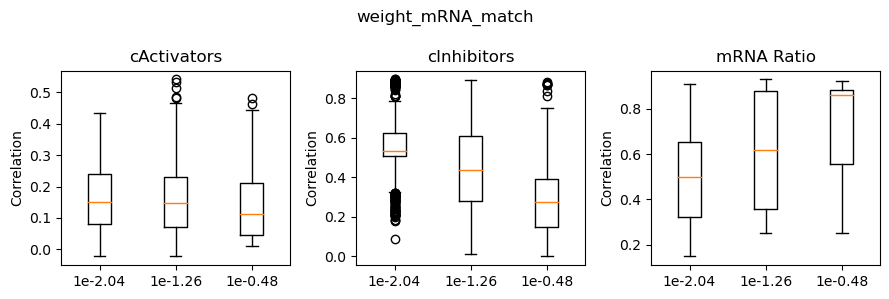

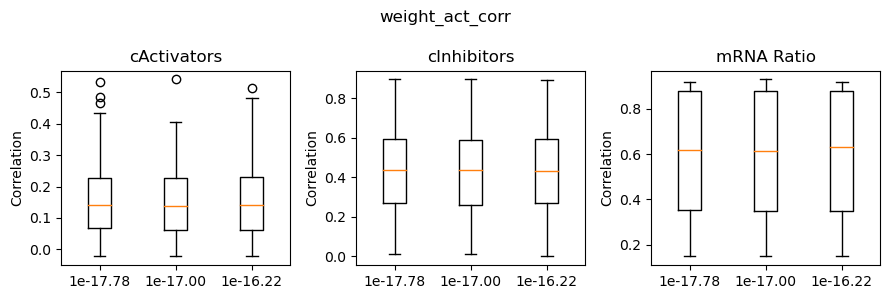

In [7]:
# search through this dataframe for meaningful information about what to set the values

# not sure how to plot this many dimensions against each other for visual effect, I also only have 3 points in each dimension so maybe that isn't helpful
# I see a few ways to do this
# 1 - for each dimension, barchart the results along 3 axes, hopefully one stands out as best in each dimension
# 2 - look at the top 20 or so values and their parameters

# first method
ct = 0
for para in paras:
    act_corr_vals = []
    inh_corr_vals = []
    mRNA_corr_vals = []
    for n in range(n_range):
        mask = [slice(None)] * len(paras)
        mask[ct] = n
        act_corr_vals.append(saved_act_corrs[tuple(mask)].flatten())
        inh_corr_vals.append(saved_inh_corrs[tuple(mask)].flatten())
        mRNA_corr_vals.append(saved_mRNA_corrs[tuple(mask)].flatten())
    ct += 1
    fig, axs = plt.subplots(1, 3, figsize = (9, 3))
    axs[0].boxplot(act_corr_vals)
    axs[0].set_ylabel('Correlation')
    axs[0].set_title('cActivators')
    try:
        axs[0].set_xticklabels(['1e{:.2f}'.format(np.log10(val)) for val in para_to_list[para]])
    except:
        axs[0].set_xticklabels([val for val in para_to_list[para]])

    
    axs[1].boxplot(inh_corr_vals)
    axs[1].set_ylabel('Correlation')
    axs[1].set_title('cInhibitors')
    try:
        axs[1].set_xticklabels(['1e{:.2f}'.format(np.log10(val)) for val in para_to_list[para]])
    except:
        axs[1].set_xticklabels([val for val in para_to_list[para]])
    
    
    axs[2].boxplot(mRNA_corr_vals)
    axs[2].set_ylabel('Correlation')
    axs[2].set_title('mRNA Ratio')
    try:
        axs[2].set_xticklabels(['1e{:.2f}'.format(np.log10(val)) for val in para_to_list[para]])
    except:
        axs[2].set_xticklabels([val for val in para_to_list[para]])
    fig.suptitle(para)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1887178/399600845.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_1887178/399600845.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


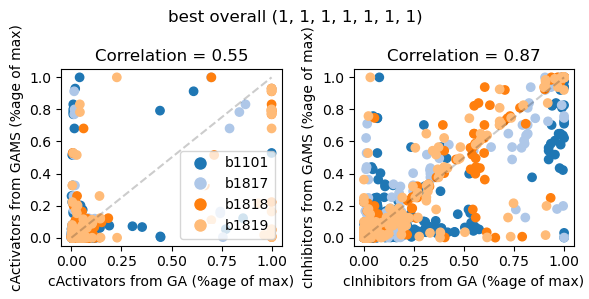

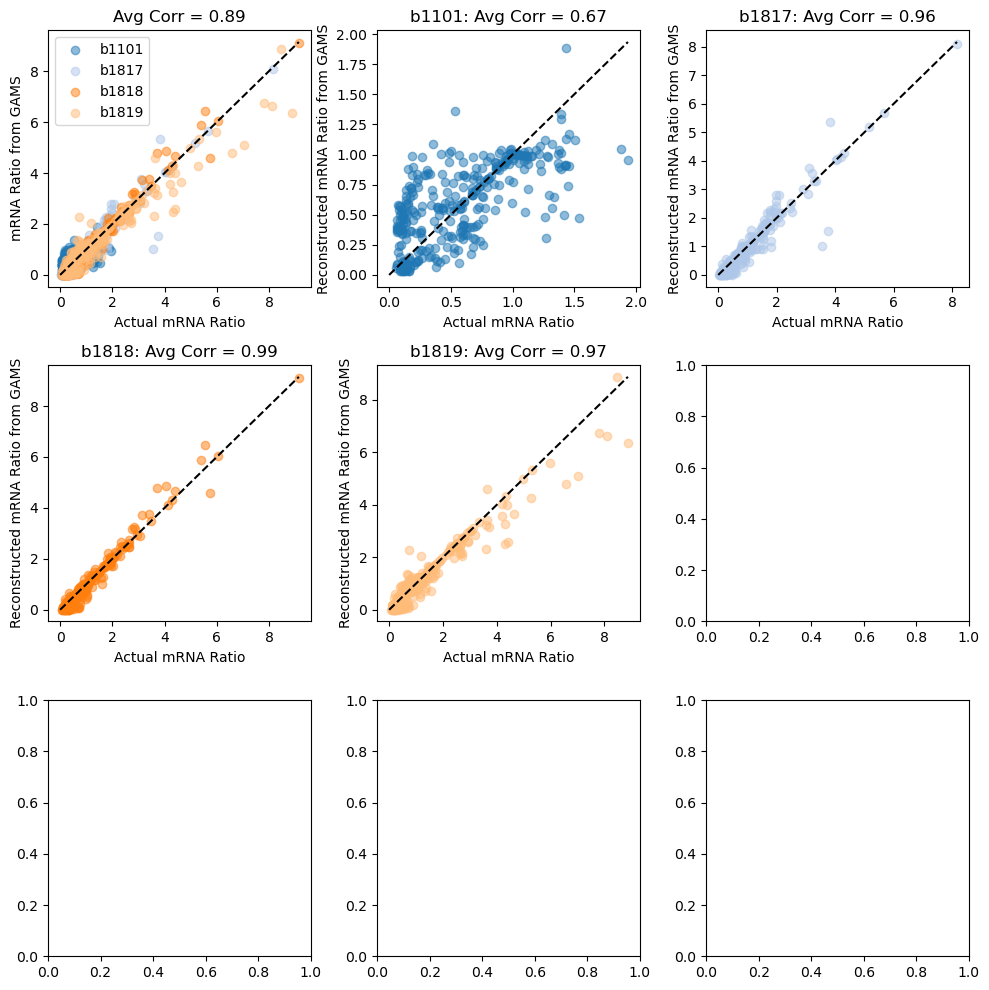

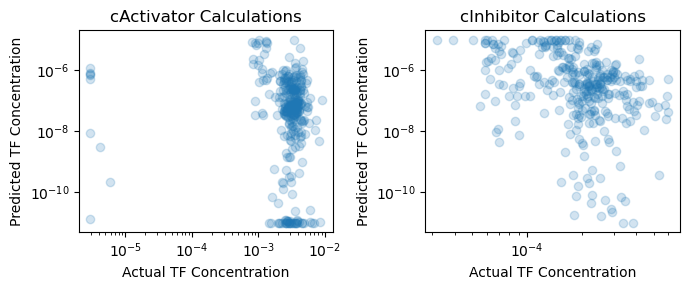

/tmp/ipykernel_1887178/399600845.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_1887178/399600845.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


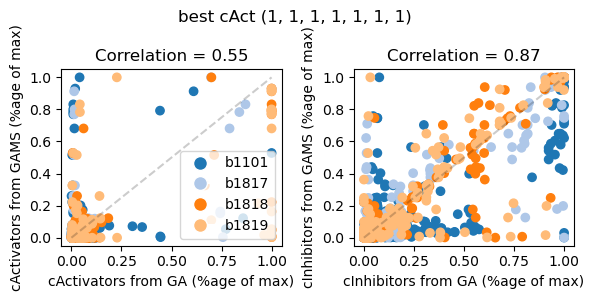

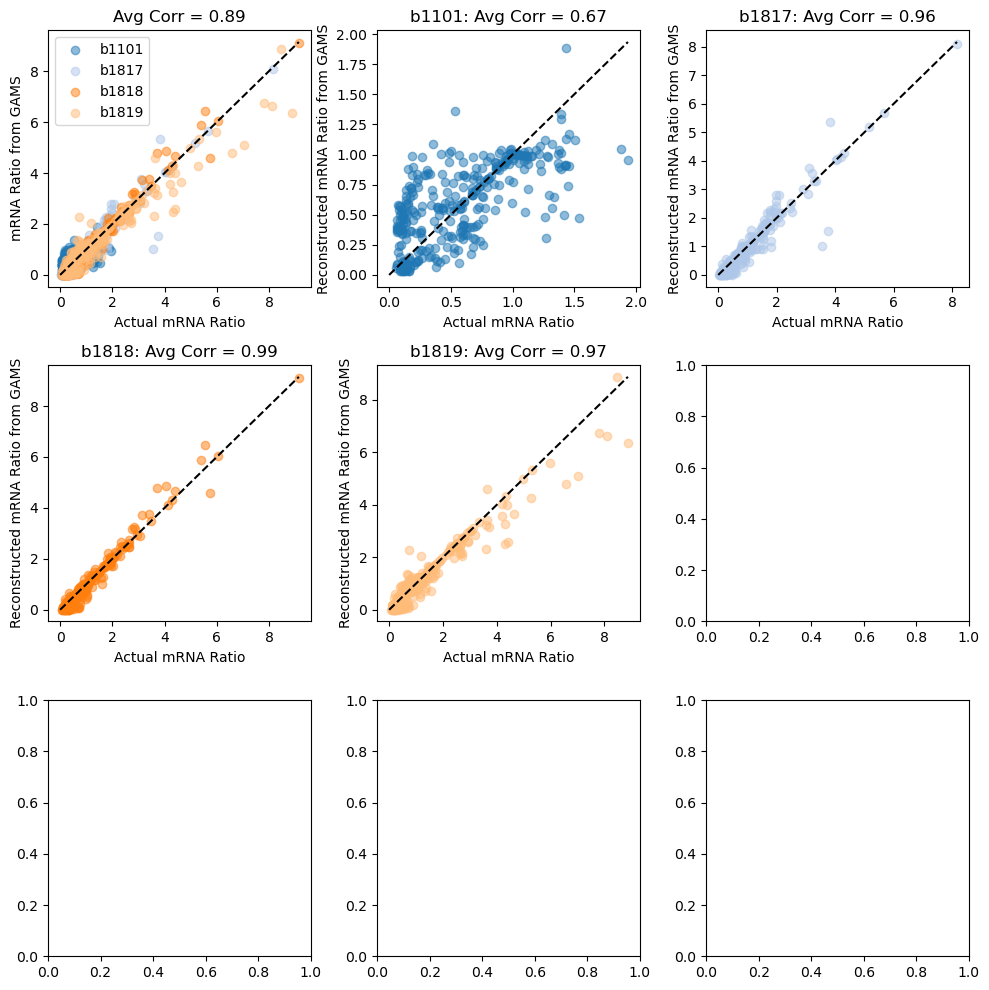

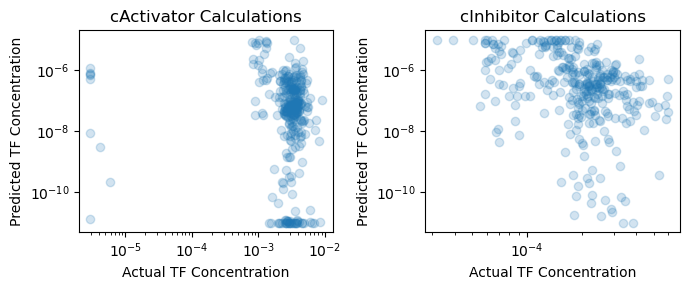

/tmp/ipykernel_1887178/399600845.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_1887178/399600845.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


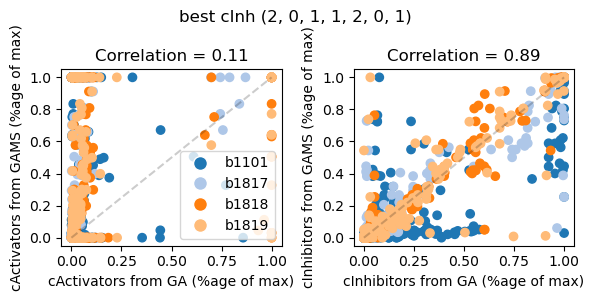

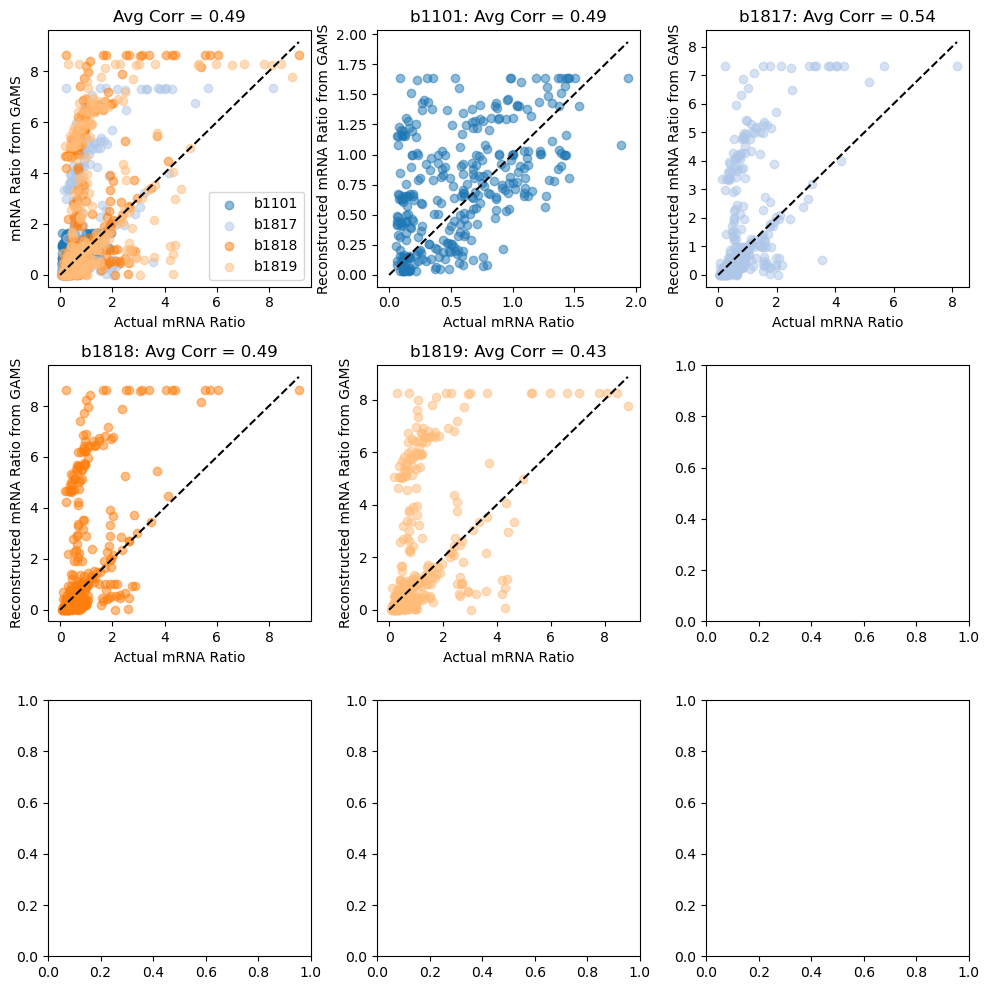

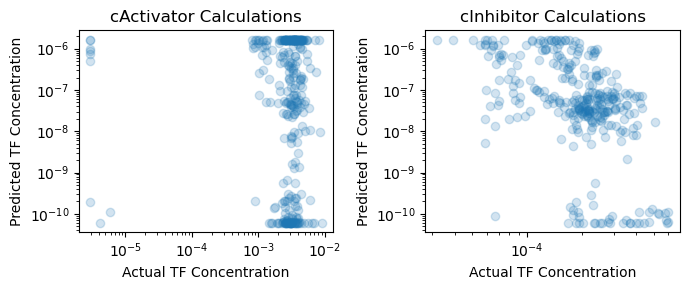

/tmp/ipykernel_1887178/399600845.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_1887178/399600845.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


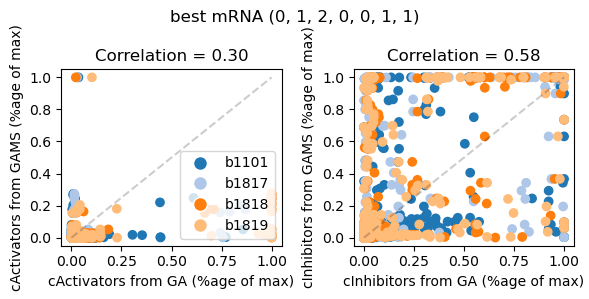

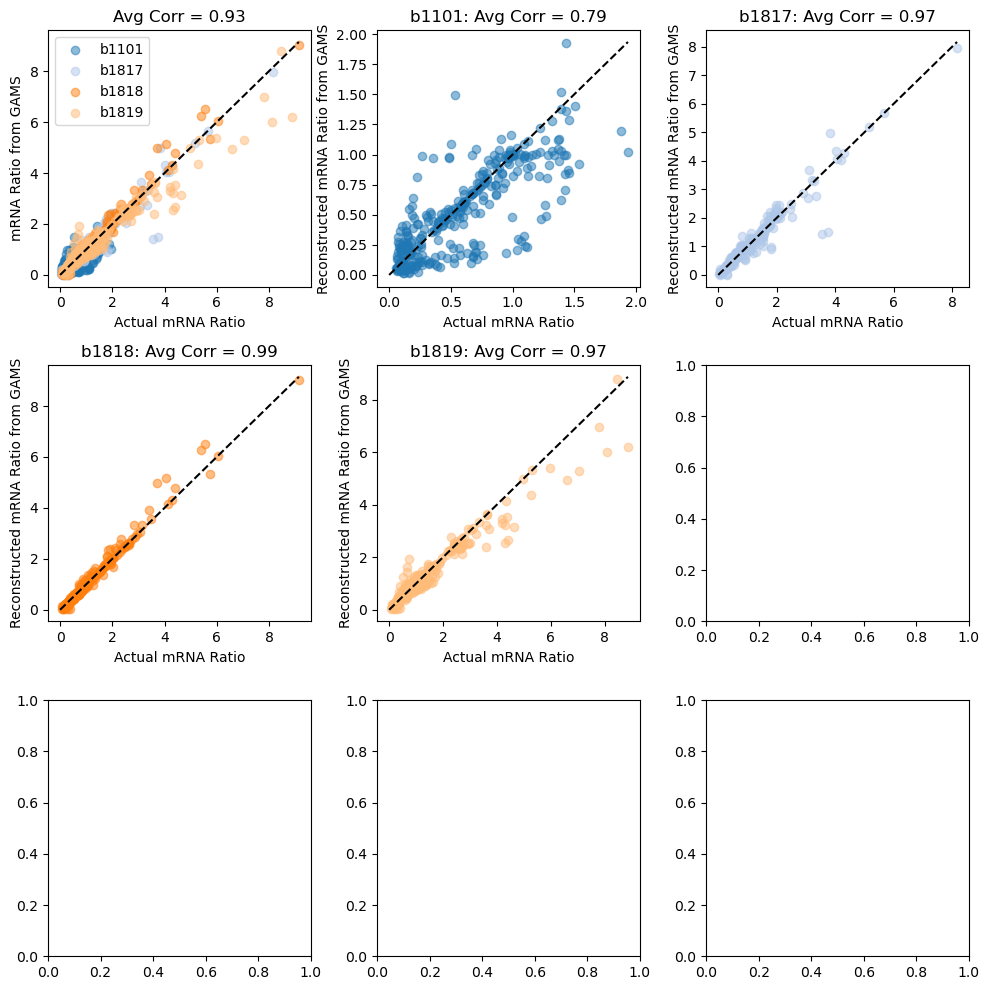

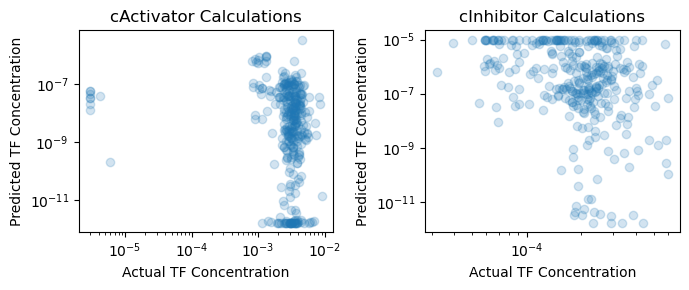

In [18]:
# let's find and visualize the best one for each metric and combining the three correlations
combo = saved_act_corrs + saved_inh_corrs + saved_mRNA_corrs
overall_best = np.unravel_index(np.argmax(combo, axis=None), np.shape(combo))
cAct_best = np.unravel_index(np.argmax(saved_act_corrs, axis=None), np.shape(saved_act_corrs))
cInh_best = np.unravel_index(np.argmax(saved_inh_corrs, axis=None), np.shape(saved_inh_corrs))
mRNA_best = np.unravel_index(np.argmax(saved_mRNA_corrs, axis=None), np.shape(saved_mRNA_corrs))
index_to_i = {v : k for k, v in i_to_index.items()}

for best_index, best_title in zip([overall_best, cAct_best, cInh_best, mRNA_best] , ['best overall', 'best cAct', 'best cInh', 'best mRNA']):
    GAMs_run_dir = '../GAMs/optimization_runs/iter_'+str(iter_ct)+'/run_'+str(index_to_i[best_index])
    # read and display GAMs
    calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(GAMs_run_dir)
    # look at GAMs results
    scale_to_100_perc = True # scale cAct / cInh by 100%

    # load in cActivators
    saved_cActivators = pd.read_csv(GAMs_run_dir+'/input_files/composite_cAct_vals.csv', index_col = 0)

    # plotting
    saved = []
    calc = []
    labels = []
    gene_to_color = {}
    cmap = cm.get_cmap('tab20')
    color_opts = iter(cmap.colors)
    colors = []
    for gene in calc_cAct.columns:
        if gene not in gene_to_color:
            gene_to_color.update({gene : next(color_opts)})
        color = gene_to_color[gene]
        for sample in calc_cAct.index:
            if scale_to_100_perc:
                saved.append(saved_cActivators.loc[sample][gene] / max(saved_cActivators[gene]))
                calc.append(calc_cAct.loc[sample][gene] / max(calc_cAct[gene]))
            else:
                saved.append(saved_cActivators.loc[sample][gene])
                calc.append(calc_cAct.loc[sample][gene])
            labels.append(gene+', '+sample)
            colors.append(color)
    fig, axs = plt.subplots(1, 2, figsize = (6, 3))
    scatter = axs[0].scatter(saved, calc, c = colors)
    if scale_to_100_perc:
        axs[0].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
    else:
        axs[0].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
    if scale_to_100_perc:
        axs[0].set_xlabel('cActivators from GA (%age of max)')
        axs[0].set_ylabel('cActivators from GAMS (%age of max)')
    else:
        axs[0].set_xlabel('cActivators from GA')
        axs[0].set_ylabel('cActivators from GAMS')
    corr = np.corrcoef(saved, calc)
    axs[0].set_title('Correlation = {:.2f}'.format(corr[1][0]))
    #plt.yscale('log')
    #plt.xscale('log')

    # Create an empty list to store legend handles and labels
    legend_elements = []
    for label, color in gene_to_color.items():
        legend_elements.append(plt.Line2D([0], [0], marker = 'o', color = 'w', markersize = 10, markerfacecolor = color, label = label))
    axs[0].legend(handles = legend_elements, loc = 'lower right')


    # now plot cInhibitor
    # load in cActivators
    saved_cActivators = pd.read_csv(GAMs_run_dir+'/input_files/composite_cInh_vals.csv', index_col = 0)

    # plotting
    saved = []
    calc = []
    labels = []
    gene_to_color = {}
    cmap = cm.get_cmap('tab20')
    color_opts = iter(cmap.colors)
    colors = []
    for gene in calc_cInh.columns:
        if gene not in gene_to_color:
            gene_to_color.update({gene : next(color_opts)})
        color = gene_to_color[gene]
        for sample in calc_cInh.index:
            if scale_to_100_perc:
                saved.append(saved_cActivators.loc[sample][gene] / max(saved_cActivators[gene]))
                calc.append(calc_cInh.loc[sample][gene] / max(calc_cInh[gene]))
            else:
                saved.append(saved_cActivators.loc[sample][gene])
                calc.append(calc_cInh.loc[sample][gene])
            labels.append(gene+', '+sample)
            colors.append(color)
    scatter = axs[1].scatter(saved, calc, c = colors)
    if scale_to_100_perc:
        axs[1].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
    else:
        axs[1].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
    if scale_to_100_perc:
        axs[1].set_xlabel('cInhibitors from GA (%age of max)')
        axs[1].set_ylabel('cInhibitors from GAMS (%age of max)')
    else:
        axs[1].set_xlabel('cInhibitors from GA')
        axs[1].set_ylabel('cInhibitors from GAMS')
    corr = np.corrcoef(saved, calc)
    axs[1].set_title('Correlation = {:.2f}'.format(corr[1][0]))
    #plt.yscale('log')
    #plt.xscale('log')
    plt.suptitle(best_title+' '+str(best_index))
    fig.tight_layout()
    plt.show()


    # I need recreated cActivators and cInhibitors
    colors = iter(plt.cm.tab20.colors)
    shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    corrs = []
    recons_mRNAs = []
    actual_mRNAs = []
    indices_for_recons = []
    max_mRNA = 0
    dims = int(np.sqrt(len(calc_cAct.columns)))+1
    fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
    axs = axs.flatten()
    #plt.figure(figsize = (4, 4))
    g_ct = 1
    grid = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0)
    ratios_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
    for gene in calc_cAct.columns:
        actual_mRNAs.append(ratios_df.loc[shared][gene])
        # setup
        po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid[gene]))

        recon_mRNA = []
        for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp']))
        recons_mRNAs.append(recon_mRNA)
        indices_for_recons.append(gene)

        actual_mRNA = ratios_df.loc[shared][gene].values.flatten()
        if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
            max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
        max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

        corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
        corrs.append(corr[0][1])
        c = next(colors)
        axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
        axs[g_ct].set_title(gene+': Avg Corr = {:.2f}'.format(corr[0][1]))
        axs[g_ct].set_xlabel('Actual mRNA Ratio')
        axs[g_ct].set_ylabel('Reconstructed mRNA Ratio from GAMS')
        g_ct += 1


    axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
    axs[0].legend()
    axs[0].set_title('Avg Corr = {:.2f}'.format(np.mean(corrs)))
    axs[0].set_xlabel('Actual mRNA Ratio')
    axs[0].set_ylabel('mRNA Ratio from GAMS')
    plt.tight_layout()
    plt.show()



    # TF conc values
    # histogram of TF_conc values
    actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_act_TF_conc.csv', index_col = 0)
    TF_conc_df = cAct_TF_conc_df
    fig, axs = plt.subplots(1, 2, figsize = (7, 3))
    axs[0].scatter(actual_TF_conc_df.loc[shared], TF_conc_df.T.loc[shared], alpha = 0.2)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Actual TF Concentration')
    axs[0].set_ylabel('Predicted TF Concentration')
    axs[0].set_title('cActivator Calculations')

    actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_inh_TF_conc.csv', index_col = 0)
    TF_conc_df = cInh_TF_conc_df
    axs[1].scatter(actual_TF_conc_df.loc[shared], TF_conc_df.T.loc[shared], alpha = 0.2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Actual TF Concentration')
    axs[1].set_ylabel('Predicted TF Concentration')
    axs[1].set_title('cInhibitor Calculations')
    plt.tight_layout()
    plt.show()

In [54]:
# print out results of the best overall one to save so you can do another run after
GAMs_run_dir = '../GAMs/optimization_runs/iter_'+str(iter_ct)+'/run_'+str(index_to_i[overall_best])
# read and display GAMs
calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(GAMs_run_dir)

params = pd.read_csv(GAMs_run_dir+'/input_files/parameters.csv', index_col = 0)
print(overall_best)
print(dict(params['Value']))
print('Overall_score: '+str(combo[overall_best]))
print('cAct_corr: '+str(saved_act_corrs[overall_best]))
print('cInh_corr: '+str(saved_inh_corrs[overall_best]))
print('mRNA_corr: '+str(saved_mRNA_corrs[overall_best]))

(0, 1, 0, 1, 2, 1, 1)
{'act_TF_conc_lo': 8e-12, 'act_TF_conc_up': 1e-05, 'act_Kd_lo': 8e-12, 'act_Kd_up': 1e-06, 'inh_TF_conc_lo': 8e-12, 'inh_TF_conc_up': 1e-05, 'inh_Kd_lo': 8e-12, 'inh_Kd_up': 1e-06, 'weight_act_obj1': 0.12, 'weight_inh_obj1': 0.12, 'weight_act_obj2': 0.0, 'weight_inh_obj2': 0.0, 'weight_mRNA_match': 0.055, 'weight_act_corr': 1e-17, 'weight_inh_corr': 1e-17}
Overall_score: 2.352089507403923
cAct_corr: 0.5643817491080189
cInh_corr: 0.8889395426128349
mRNA_corr: 0.8987682156830695
